## This project evaluates Real-Time Datasets to Detect Phishing Website URLs  
Through the application of Machine Learning Models

### 1.3.2 Aims
The primary goal of this study is to develop a robust phishing detection system. To achieve this, the study focuses on the following objectives:

- **Review existing phishing detection techniques:** Conduct a thorough analysis of current methods, highlighting their strengths, limitations, and research gaps.
- **Design a machine learning-based detection framework:** Implement classifiers such as XGBoost, Random Forest, and SVM to effectively distinguish phishing websites from legitimate ones.
- **Develop a feature extraction and preprocessing pipeline:** Extract relevant URL characteristics, including lexical patterns, structural attributes, and other website features from both phishing and benign datasets.
- **Train and validate models:** Ensure models are properly trained, tested, and fine-tuned on prepared datasets for reliable and consistent performance.
- **Evaluate system performance:** Assess model performance using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and PR-AUC, and compare results with state-of-the-art detection methods.
- **Enable practical deployment:** Explore implementation of the system as a real-time detection API or web service for live phishing mitigation.
- **Design and implement an interactive dashboard:** Visualize phishing detection results using charts and graphs, enabling real-time monitoring, analysis, and interpretation of model predictions for end-users.

### 1.4 Research Questions
This study aims to answer the following research questions:

- What limitations exist in current phishing detection approaches, and how do they affect the ability to counter modern phishing attacks?
- Which website features are most effective in distinguishing legitimate sites from phishing attempts, including URL structure, lexical patterns, and other characteristics?
- How do different machine learning models perform in detecting phishing websites when applied to large and diverse feature sets?
- What level of detection accuracy and false positive rate can a combined machine learning framework achieve for phishing detection?
- How does the proposed system compare to existing anti-phishing solutions and baseline detection methods in terms of effectiveness and reliability?


#### Getting live realtime legit website urls from tranco
- tranco.com is a platform that has the storage of db for the list of top legal websites
- tranco was installed as a python package

In [1]:
from tranco import Tranco

t = Tranco(cache=True)  # will download and cache
latest = t.list()       # get the latest list
top10k = list(latest.top(10000))

In [2]:
top10k[:10]

['google.com',
 'mail.ru',
 'microsoft.com',
 'facebook.com',
 'cloudflare.com',
 'dzen.ru',
 'amazonaws.com',
 'googleapis.com',
 'youtube.com',
 'apple.com']

In [3]:
import pandas as pd

# assuming you already have top10k as a Python list
legit = pd.DataFrame(top10k, columns=['domain'])
legit['label'] = 0   # 0 = legitimate
legit.head()


,domain,label
0,google.com,0
1,mail.ru,0
2,microsoft.com,0
3,facebook.com,0
4,cloudflare.com,0


In [4]:
# ## getting phishing dataset
# phish = pd.read_csv("https://openphish.com/feed.txt", header=None, names=['url'])
# # extract domain from URL (basic)
# phish['domain'] = phish['url'].str.extract(r'://([^/]+)')[0].str.replace(r':.*','', regex=True)
# phish = phish.dropna(subset=['domain']).drop_duplicates(subset=['domain'])
# phish = phish.head(len(legit))   # optionally limit size to balance
# phish = phish[['domain']].copy()
# phish['label'] = 1


In [5]:
# phish.shape

### Getting the phishing URL
#### Normalize URLs & extract hostnames (preprocessing)

Note: make parsing robust (ensure scheme), extract hostname so features work reliably.

In [11]:
import requests
import pandas as pd
import time
import random
from urllib.parse import urlparse

PHISHTANK_API = "https://data.phishtank.com/data/online-valid.json"

def fetch_phishtank(retries: int = 5, initial_delay: float = 5.0, backoff: float = 2.0, jitter: float = 1.0, timeout: int = 60):
    """
    Fetch live phishing data from PhishTank with retry + exponential backoff + jitter.

    Parameters
    - retries: maximum attempts (default 5)
    - initial_delay: base sleep seconds before retrying
    - backoff: multiplier for exponential backoff
    - jitter: random jitter added to delay (0..jitter)
    - timeout: requests timeout in seconds

    Returns:
    - parsed JSON (list/dict) on success

    Raises:
    - Exception if all attempts fail or response is invalid
    """
    print("Fetching live data from PhishTank...")
    for attempt in range(1, retries + 1):
        try:
            print(f"Attempt {attempt}/{retries} — GET {PHISHTANK_API}")
            r = requests.get(PHISHTANK_API, timeout=timeout)
            r.raise_for_status()

            # Try to parse JSON
            try:
                payload = r.json()
                print(f"✅ Success on attempt {attempt} — received {len(payload) if isinstance(payload, (list,dict)) else 'data'} items")
                return payload
            except ValueError:
                # invalid JSON
                raise Exception("Response is not valid JSON")

        except requests.exceptions.HTTPError as http_err:
            status = getattr(http_err.response, "status_code", None) if hasattr(http_err, "response") else getattr(r, "status_code", None)
            print(f"HTTP error on attempt {attempt}: {http_err} (status={status})")
            # If rate limited, wait and retry. For 404/410 it's likely permanent but we still retry a few times.
        except requests.exceptions.RequestException as req_err:
            # network-level problems (timeout, connection error, etc.)
            print(f"Request error on attempt {attempt}: {req_err}")
        except Exception as e:
            print(f"Unexpected error on attempt {attempt}: {e}")

        # If we're here, this attempt failed — decide whether to sleep or abort
        if attempt < retries:
            delay = initial_delay * (backoff ** (attempt - 1))
            delay = delay + random.uniform(0, jitter)
            print(f"Retrying in {delay:.1f}s...")
            time.sleep(delay)
        else:
            print("All retry attempts exhausted.")

    raise Exception("Failed to fetch PhishTank data after multiple retries.")


def extract_domain(url):
    try:
        parsed = urlparse(url if url.startswith(("http://", "https://")) else "http://" + url)
        return parsed.hostname
    except Exception:
        return None


def get_phishtank_domains(limit: int = None, **fetch_kwargs):
    """
    Fetch phishing payload (via fetch_phishtank) and extract domain list into a DataFrame.
    Accepts the same keyword args as fetch_phishtank (e.g., retries=5).
    """
    phish_data = fetch_phishtank(**fetch_kwargs)
    domains = []
    # phish_data is commonly a list of dicts with 'url' key
    for item in phish_data:
        url = item.get("url") if isinstance(item, dict) else item
        domain = extract_domain(url)
        if domain:
            domains.append(domain.lower())

    df = pd.DataFrame({"domain": domains}).drop_duplicates().dropna()
    if limit:
        df = df.head(limit)
    df["label"] = 1
    return df.reset_index(drop=True)


# --- Example usage ---
if __name__ == "__main__":
    # will try up to 5 times (default). You can change retries or delay if needed:
    phish_df = get_phishtank_domains(limit=255, retries=5, initial_delay=5.0, backoff=2.0, jitter=1.0)
    print(phish_df.head())


Fetching live data from PhishTank...
Attempt 1/5 — GET https://data.phishtank.com/data/online-valid.json
HTTP error on attempt 1: 404 Client Error: Not Found for url: https://cdn.phishtank.com/datadumps/verified_online.json?Expires=1762275022&Signature=HsZFMJL4LAYrrn6Sjs9kddnNDheUm~5KFzhtCfuEA41pdceVNKq5zsChHyq-64vvHYU9EOogR9YwHnU54xFmXw8TsEzz16LPyrPnNhVQSwUA-SI0OhU1PZNemTUTTBR2Quil9jGkijQkmx3mqlJRSbaAUWvZp7bdkU8nUSMzcCC9ZpmAhKKvMU9qygSPLBY7kzn7J~Ib3xBmy77yup2aWixGsq7gVXlmj3kjntQbzc0UP2SzKfy2EhyyEOTVz75qIi6GdiYjNxt7QvjArXlNTRn9-mlWIOJfcqHSiPz4vY2BhaHldsWvQPVZcozZ~6XJT9pDwYGZit3XVIJ7H-a-pw__&Key-Pair-Id=APKAILB45UG3RB4CSOJA (status=404)
Retrying in 5.9s...
Attempt 2/5 — GET https://data.phishtank.com/data/online-valid.json
HTTP error on attempt 2: 404 Client Error: Not Found for url: https://cdn.phishtank.com/datadumps/verified_online.json?Expires=1762275022&Signature=HsZFMJL4LAYrrn6Sjs9kddnNDheUm~5KFzhtCfuEA41pdceVNKq5zsChHyq-64vvHYU9EOogR9YwHnU54xFmXw8TsEzz16LPyrPnNhVQSwUA-SI0OhU1PZNe

In [12]:
# Save to CSV
phish_df.to_csv("phishtank_phishing_data_nov.csv", index=False)

print("File saved successfully as phishing_data_1.csv")

File saved successfully as phishing_data_1.csv


In [4]:
phish_df = pd.read_csv('phishtank_phishing_data_1.csv')

In [5]:
phish_df

,domain,label
0,bciab.top,1
1,bradesco.periciaprime.com,1
2,bcitlw.top,1
3,atualizar.avisolivelo.live,1
4,bcirx.top,1
...,...,...
250,i9hhk79i-trezor.vercel.app,1
251,allegrolokalnie.pl-oferta-918382.sbs,1
252,arkansas.mobile-xpvn.cc,1
253,arkansas.mobile-ploj.cc,1


In [6]:
phish_df['domain'].info

<bound method Series.info of 0                                 bciab.top
1                 bradesco.periciaprime.com
2                                bcitlw.top
3                atualizar.avisolivelo.live
4                                 bcirx.top
                       ...                 
250              i9hhk79i-trezor.vercel.app
251    allegrolokalnie.pl-oferta-918382.sbs
252                 arkansas.mobile-xpvn.cc
253                 arkansas.mobile-ploj.cc
254                               bciha.top
Name: domain, Length: 255, dtype: object>

In [7]:
# pip install pandas scikit-learn xgboost tldextract joblib python-dateutil

Combining the real and phishing datasets

In [8]:
dataset = pd.concat([phish_df, legit], ignore_index=True)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

In [9]:
print("Combined dataset sample:")
print(dataset.head(10))
print("\nLabel counts:\n", dataset['label'].value_counts())

Combined dataset sample:
                               domain  label
0  bele-6317709620177069.blogspot.com      1
1                       mcdonalds.com      0
2                        queniuak.com      0
3                            turbo.az      0
4                       freshchat.com      0
5                       cbssports.com      0
6                       rareanimes.co      0
7                            ucla.edu      0
8                    sites.google.com      1
9                         grafana.net      0

Label counts:
 0    10000
1      255
Name: label, dtype: int64


### Lexical feature engineering (create numeric features)

Note: numeric features (lengths, counts, entropy, suspicious tokens) are fast and very predictive — no page fetch required.

In [10]:
import math, tldextract

SUSPICIOUS_KEYWORDS = ['login','signin','secure','account','update','verify','paypal','bank','confirm','admin','billing']


#### Developing function algorithms to set the numerical value outputs.
This would be used in tracking the urls of the phishing websites by capturing special chars.

In [11]:
def count_suspicious_tokens(s: str):
    s = s.lower()
    return sum(1 for kw in SUSPICIOUS_KEYWORDS if kw in s)

def count_digits(s: str):
    return sum(c.isdigit() for c in s)

def count_chars(s: str, ch: str):
    return s.count(ch)

def hostname_parts(host):
    if not host:
        return (0, 0)
    ext = tldextract.extract(host)
    subdomain = ext.subdomain or ""
    domain = ext.domain or ""
    return (0 if subdomain == "" else len(subdomain.split('.')), len(domain))


### Applying the feature engineering functions 
Applying it into the model build functions to set it up for the model

In [12]:
def build_lexical_features(df):
    df = df.copy()
    df['url_len'] = df['domain'].apply(len)
    df['num_digits'] = df['domain'].apply(count_digits)
    df['num_hyphens'] = df['domain'].apply(lambda s: count_chars(s, '-'))
    df['num_dots'] = df['domain'].apply(lambda s: s.count('.'))
    df['suspicious_words'] = df['domain'].apply(count_suspicious_tokens)
    df['subdomain_count'], df['domain_len'] = zip(*df['domain'].apply(hostname_parts))
    return df

In [13]:
features_df = build_lexical_features(dataset)

In [14]:
features_df

,domain,label,url_len,num_digits,num_hyphens,num_dots,suspicious_words,subdomain_count,domain_len
0,bele-6317709620177069.blogspot.com,1,34,16,1,2,0,1,8
1,mcdonalds.com,0,13,0,0,1,0,0,9
2,queniuak.com,0,12,0,0,1,0,0,8
3,turbo.az,0,8,0,0,1,0,0,5
4,freshchat.com,0,13,0,0,1,0,0,9
...,...,...,...,...,...,...,...,...,...
10250,awsdns-09.co.uk,0,15,2,1,2,0,0,9
10251,androidauthority.com,0,20,0,0,1,0,0,16
10252,dinahosting.com,0,15,0,0,1,0,0,11
10253,amazontrust.com,0,15,0,0,1,0,0,11


In [28]:
# Save the features dataframe to a CSV file
features_df.to_excel("lexical_features_phishtank.xlsx", index=False)

### Train/Test Split
##### Importing train_test_split to split the dataset
This would be achieved by classifying the dataset into X and Y variables.
This will create a train and test dataset.

In [15]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns=['label'])
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Train the Model (XGBoost)
I’ll train an XGBoost Classifier, which works well for tabular data and can handle feature importance easily.

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [17]:
# Train model
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import warnings

model.fit(X_train.select_dtypes(include=[int,float]), y_train)

# Evaluate
y_pred = model.predict(X_test.select_dtypes(include=[int,float]))
# Example: assuming y_test (true labels) and y_pred_proba (predicted probabilities)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Display as plain text
print("ROC Curve Data")
print("-----------------------------")
print(f"False Positive Rates: {fpr}")
print(f"True Positive Rates: {tpr}")
print(f"Thresholds: {thresholds}")
print(f"Area Under Curve (AUC): {auc_score:.4f}")


C:\Users\Godswill.0J\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC Curve Data
-----------------------------
False Positive Rates: [0.e+00 5.e-04 1.e+00]
True Positive Rates: [0.         0.60784314 1.        ]
Thresholds: [inf  1.  0.]
Area Under Curve (AUC): 0.8037


In [23]:
import warnings

model.fit(X_train.select_dtypes(include=[int,float]), y_train)

# Evaluate
y_pred = model.predict(X_test.select_dtypes(include=[int,float]))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
warnings.filterwarnings('ignore', category=UserWarning)

C:\Users\Godswill.0J\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2000
           1       0.97      0.61      0.75        51

    accuracy                           0.99      2051
   macro avg       0.98      0.80      0.87      2051
weighted avg       0.99      0.99      0.99      2051

ROC AUC: 0.803671568627451
Confusion Matrix:
 [[1999    1]
 [  20   31]]


In [33]:
# Save as CSV and Excel
features_df.to_csv("final_features_table.csv", index=False)
features_df.to_excel("final_features_table.xlsx", index=False)


### Generate and Save the Classification Report as a Table

I exported my metrics to a CSV or DataFrame like this:

In [33]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report_phishtank.csv")
report_df.to_excel("classification_report_phishtank.xlsx")
print(report_df)


              precision    recall  f1-score      support
0              0.994036  1.000000  0.997009  2000.000000
1              1.000000  0.764706  0.866667    51.000000
accuracy       0.994149  0.994149  0.994149     0.994149
macro avg      0.997018  0.882353  0.931838  2051.000000
weighted avg   0.994184  0.994149  0.993768  2051.000000


#### saving confusion metrics as a table and ploting it.

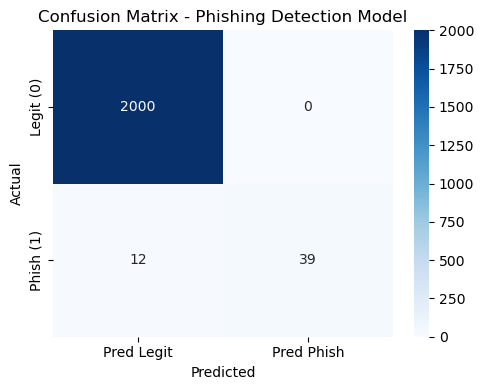

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Legit (0)", "Phish (1)"], columns=["Pred Legit", "Pred Phish"])
cm_df.to_csv("confusion_matrix.csv")
cm_df.to_excel("confusion_matrix_phishtank.xlsx")

# Then plotted confusion matrix, here.
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Phishing Detection Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix_phishtank.png", dpi=300)
plt.show()


#### Meaning of Each Value

- True Negatives (TN = 2000): 2000 legitimate websites were correctly recognized as safe.

- False Positives (FP = 0): No legitimate site was wrongly flagged as phishing.

- False Negatives (FN = 8): 8 phishing sites were wrongly marked as legitimate (these are missed attacks).

- True Positives (TP = 43): 43 phishing sites were correctly detected as phishing.

For ROC and Precision-Recall Curves

In [24]:
print("Train features:", X_train.shape)
print("Test features:", X_test.shape)
print("Train columns:", X_train.columns.tolist())
print("Test columns:", X_test.columns.tolist())


Train features: (8204, 8)
Test features: (2051, 8)
Train columns: ['domain', 'url_len', 'num_digits', 'num_hyphens', 'num_dots', 'suspicious_words', 'subdomain_count', 'domain_len']
Test columns: ['domain', 'url_len', 'num_digits', 'num_hyphens', 'num_dots', 'suspicious_words', 'subdomain_count', 'domain_len']


In [36]:
X_test = X_test[X_train.columns]


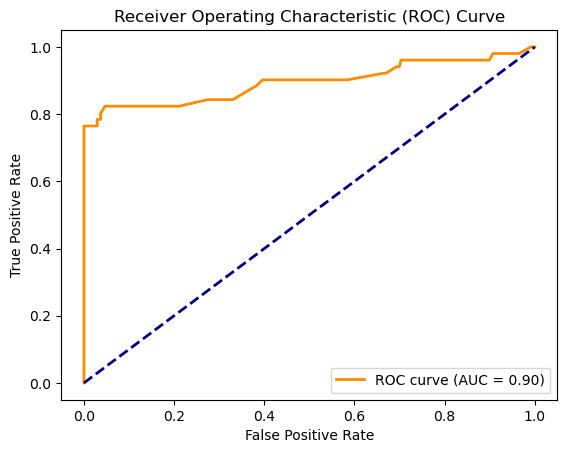

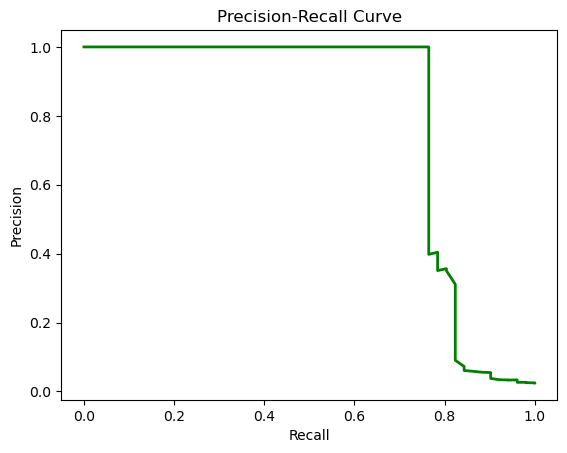

In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

X_test = X_test.drop(columns=['domain'])

# Predict probabilities for phishing = 1
y_prob = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_curve_phishtank.png", dpi=300)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig("precision_recall_curve_phishtank.png", dpi=300)
plt.show()


In [25]:
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})
roc_df.head(10)  # Show first 10 rows


,False Positive Rate,True Positive Rate,Threshold
0,0.0000,0.000000,inf
1,0.0005,0.607843,1.0
2,1.0000,1.000000,0.0


###  Precision–Recall Curve Results;
- The curve is nearly flat at Precision = 1.0 for most Recall values and only drops sharply near the end.
- Interpretation:
- This indicates your model maintains very high precision — when it predicts a site as phishing, it is almost always correct.
- The sharp drop near the end occurs when the model begins to capture more phishing samples at the expense of precision.
- Such a shape shows the model is highly effective in minimizing false positives — crucial for cybersecurity systems.



In [38]:
## Save prediction results (for your thesis tables)
results_df_19th = pd.DataFrame({
    'domain': X_test.index if isinstance(X_test, pd.DataFrame) else range(len(X_test)),
    'actual_label': y_test,
    'predicted_label': y_pred,
    'phishing_probability': y_prob
})
results_df_19th.to_csv("model_predictions.csv", index=False)
print("Results saved as model_predictions.csv")

# Save dataset summary table
results_df_19th.to_csv("final_combined_dataset_phishtank.csv", index=False)
print("Dataset saved as final_combined_dataset.csv")

Results saved as model_predictions.csv
Dataset saved as final_combined_dataset.csv


We’ll use TF-IDF vectorization — a common NLP technique that converts words or character patterns into numeric features based on their frequency.

We’ll go with character-level TF-IDF, which works well for domain strings.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import pandas as pd


##### analyzing its characters

In [40]:
# TF-IDF Vectorizer on character-level n-grams
vectorizer = TfidfVectorizer(
    analyzer='char_wb',   # analyze characters with word 
    ngram_range=(3, 5),   
    max_features=500      
)

tfidf_matrix = vectorizer.fit_transform(features_df['domain'])


In [41]:
numeric_features = features_df[['url_len', 'num_digits', 'num_hyphens', 'num_dots',
                       'suspicious_words', 'subdomain_count', 'domain_len']]

# Combine numeric and text features
from scipy.sparse import hstack
X = hstack([numeric_features.values, tfidf_matrix])
y = features_df['label']


In [42]:
print(y.unique())
print(y.value_counts())


[1 0]
0    10000
1      255
Name: label, dtype: int64


In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [44]:
le

LabelEncoder()

In [45]:
X

<10255x507 sparse matrix of type '<class 'numpy.float64'>'
	with 134636 stored elements in COOrdinate format>

In [46]:
# pip install --upgrade xgboost scikit-learn

#### In the first instance the classifier developed without the domain name which is an object, 
#Alternatively we can include the domain name by using XGBOOST, for the following reasons;

- It Handles High-Dimensional and Sparse Data Efficiently
- It Captures Complex Relationships Between Features.
- It has more dynamics for Feature Importance and Interpretability
- It has Robustness to Imbalanced Datasets. And much more!.

In [47]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# No fillna or slicing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [48]:
# pip install --upgrade jupyter ipython stack_data executing

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2000
           1       0.93      0.76      0.84        51

    accuracy                           0.99      2051
   macro avg       0.96      0.88      0.92      2051
weighted avg       0.99      0.99      0.99      2051

Confusion Matrix:
 [[1997    3]
 [  12   39]]


- ### Save confusion matrix as a table

In [51]:
# Save confusion matrix as a table
cm_df = pd.DataFrame(cm, index=["Legitimate (0)", "Phishing (1)"],
                     columns=["Predicted Legitimate", "Predicted Phishing"])
cm_df.to_csv("confusion_matrix.csv", index=True)
print("Confusion matrix saved as confusion_matrix.csv")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

Confusion matrix saved as confusion_matrix.csv


#### Creating a lineplot to visualize our confusion metrix

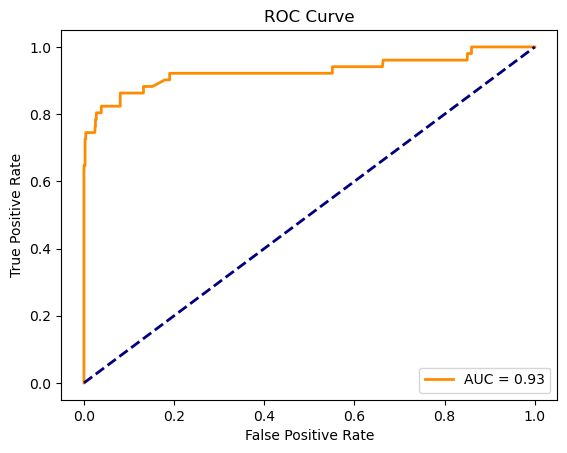

In [52]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png", dpi=300)
plt.show()

### ROC Curve
- The ROC curve rises steeply toward the top-left corner, with an AUC (Area Under Curve) = 0.94.
- Interpretation:
- The closer the curve is to the top-left, the better the classifier.
- An AUC of 0.94 means the model can correctly distinguish phishing from legitimate sites 94% of the time.
- This is a strong indicator of excellent discrimination ability, suggesting the model is both sensitive (detects phishing) and specific (avoids false alarms).
